# Lugar ideal (nome da aplicação TBD)

Aplicação que utiliza algoritmos não-supervisionados de agrupamento para sugerir moradias de melhor custo-benefício de acordo com preferências do usuário. 


Obs: Inicialmente estou definindo o parâmetro Custo-beneficio como a razão entre área do imóvel e preço do aluguel. A ideia é usar o custo-beneficio como score para definir o melhor lugar pras buscas dos usuários

Uma definição do custo beneficio mais apurada deve incluir tanto informações dadas pelo usuário quanto o "nível de importância" (ou peso) de cada uma das preferências.  


In [103]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns


## 1. Data cleaning

Nessa parte vamos:

1. criar um unico pandas data frame com todos os dados raspados do site quinto andar
2. criar uma coluna para assinalar o bairro

In [18]:
# Pasta onde os dados estão salvos
folder = r"D:\Tech-Challenge-QuintoAndar\database\data"

# Lista todos os arquivos csv na pasta
files = [f for f in os.listdir(folder) if f.endswith(".csv")]

# concatenando dados em um unico data set
dfs = []
for f in files:
    path = os.path.join(folder, f)
    df = pd.read_csv(path)
    # Adicionando uma coluna com o bairro
    neighborhood = os.path.splitext(f)[0].replace("quintoandar_", "")
    df["neighborhood"] = neighborhood.split('_')[0]
    dfs.append(df)

# Merge all into one DataFrame
data = pd.concat(dfs, ignore_index=True)

print("Merged shape:", data.shape)
data.head()

Merged shape: (2145, 20)


,url,status,title,address_street,area,quartos,suite,banheiros,vagas,andar,pet,mobiliado,metro_proximo,Aluguel,Condomínio,IPTU,Seguro incêndio,Taxa de serviço,Total,neighborhood
0,https://www.quintoandar.com.br/imovel/89496410...,success,"Studio para alugar com 25m², 1 quarto e sem vaga",Rua Eleutério,25.0,1.0,1,1.0,NaN,20° a 23° andar,não,sim,sim,R$ 3.500,R$ 550,R$ 0,R$ 45,R$ 90,R$ 4.185,brooklin
1,https://www.quintoandar.com.br/imovel/89460040...,success,"Apartamento para alugar com 116m², 3 quartos e...",Condomínios em São Paulo,116.0,3.0,2,3.0,2.0,Até 3° andar,sim,sim,sim,R$ 10.000,R$ 1.300,R$ 0,R$ 127,R$ 259,R$ 11.686,brooklin
2,https://www.quintoandar.com.br/imovel/89499927...,success,"Apartamento para alugar com 28m², 1 quarto e s...",Avenida Santo Amaro,28.0,1.0,1,1.0,NaN,8° a 11° andar,não,sim,sim,R$ 2.950,R$ 760,R$ 0,R$ 38,R$ 76,R$ 3.824,brooklin
3,https://www.quintoandar.com.br/imovel/89506631...,success,"Studio para alugar com 26m², 1 quarto e sem vaga",Rua Eleutério,26.0,1.0,0,1.0,NaN,8° a 11° andar,sim,não,sim,R$ 2.700,R$ 550,R$ 1,R$ 35,R$ 69,R$ 3.355,brooklin
4,https://www.quintoandar.com.br/imovel/89495522...,success,"Studio para alugar com 32m², 1 quarto e 1 vaga",Avenida Portugal,32.0,1.0,0,1.0,1.0,16° a 19° andar,não,sim,sim,R$ 3.680,R$ 600,R$ 100,R$ 47,R$ 95,R$ 4.522,brooklin


Continuando a etapa de data cleaning, a seguir vamos:

3. Substituir entradas NaN (ocorrem principalmente na coluna 'vaga') por 0 
4. substituir "não" por 0 e "sim" por 1 em todas aparições
5. remover R$ das tabelas de preços e reescrever valores como float

In [ ]:
# 1. Replace NaN with 0
data = data.fillna(0)

# 2. Convert 'sim' / 'não' to 1 / 0 in specific columns
bool_cols = ["pet", "mobiliado", "metro_proximo"]

for col in bool_cols:
    data[col] = data[col].astype(str).str.strip().str.lower()
    data[col] = data[col].replace({"sim": 1, "não": 0, "nao": 0})
    data[col] = data[col].astype(int)

# 3. Clean price columns (remove "R$" and convert to float)
price_cols = ["Aluguel", "Condomínio", "Seguro incêndio", "Total", "IPTU", "Taxa de serviço"]  

for col in price_cols:
    data[col] = (
        data[col]
        .astype(str)
        .str.replace("R$", "", regex=False)
        .str.replace(".", "", regex=False)  
        .str.replace(",", ".", regex=False)  
        .str.strip()
    )
    data[col] = pd.to_numeric(data[col], errors="coerce").fillna(0)


   pet  mobiliado  metro_proximo  Aluguel  Condomínio  Seguro incêndio  Total  \
0    0          1              1     3500       550.0               45   4185   
1    1          1              1    10000      1300.0              127  11686   
2    0          1              1     2950       760.0               38   3824   
3    1          0              1     2700       550.0               35   3355   
4    0          1              1     3680       600.0               47   4522   

   IPTU  Taxa de serviço  
0     0               90  
1     0              259  
2     0               76  
3     1               69  
4   100               95  


C:\Users\josea\AppData\Local\Temp\ipykernel_17660\1240748502.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[col] = data[col].replace({"sim": 1, "não": 0, "nao": 0})
C:\Users\josea\AppData\Local\Temp\ipykernel_17660\1240748502.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[col] = data[col].replace({"sim": 1, "não": 0, "nao": 0})
C:\Users\josea\AppData\Local\Temp\ipykernel_17660\1240748502.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the o

In [20]:
data.head()

,url,status,title,address_street,area,quartos,suite,banheiros,vagas,andar,pet,mobiliado,metro_proximo,Aluguel,Condomínio,IPTU,Seguro incêndio,Taxa de serviço,Total,neighborhood
0,https://www.quintoandar.com.br/imovel/89496410...,success,"Studio para alugar com 25m², 1 quarto e sem vaga",Rua Eleutério,25.0,1.0,1,1.0,0.0,20° a 23° andar,0,1,1,3500,550.0,0,45,90,4185,brooklin
1,https://www.quintoandar.com.br/imovel/89460040...,success,"Apartamento para alugar com 116m², 3 quartos e...",Condomínios em São Paulo,116.0,3.0,2,3.0,2.0,Até 3° andar,1,1,1,10000,1300.0,0,127,259,11686,brooklin
2,https://www.quintoandar.com.br/imovel/89499927...,success,"Apartamento para alugar com 28m², 1 quarto e s...",Avenida Santo Amaro,28.0,1.0,1,1.0,0.0,8° a 11° andar,0,1,1,2950,760.0,0,38,76,3824,brooklin
3,https://www.quintoandar.com.br/imovel/89506631...,success,"Studio para alugar com 26m², 1 quarto e sem vaga",Rua Eleutério,26.0,1.0,0,1.0,0.0,8° a 11° andar,1,0,1,2700,550.0,1,35,69,3355,brooklin
4,https://www.quintoandar.com.br/imovel/89495522...,success,"Studio para alugar com 32m², 1 quarto e 1 vaga",Avenida Portugal,32.0,1.0,0,1.0,1.0,16° a 19° andar,0,1,1,3680,600.0,100,47,95,4522,brooklin


In [22]:
data.columns

Index(['url', 'status', 'title', 'address_street', 'area', 'quartos', 'suite',
       'banheiros', 'vagas', 'andar', 'pet', 'mobiliado', 'metro_proximo',
       'Aluguel', 'Condomínio', 'IPTU', 'Seguro incêndio', 'Taxa de serviço',
       'Total', 'neighborhood', 'price_per_m2'],
      dtype='object')

Olhando as colunas que temos, notamos que alguns atributos que, em princípio, não são relevantes para nossa aplicação. Por isso, definimos um novo data frame (data_refined) considerando apenas os parâmetros mais importantes: area, quartos, suite, banheiro, vagas, pet, mobiliado, metro_proximo, aluguel, 'Condomínio', 'IPTU', 'Seguro incêndio', 'Taxa de serviço', 'Total', 'neighborhood', 'price_per_m2'

In [43]:
data_refined = data.copy() 

# Drop unwanted columns
cols_to_drop = ["url", "status", "title", "address_street", "andar"]
data_refined = data_refined.drop(columns=cols_to_drop, errors="ignore")

data_refined.head()

,area,quartos,suite,banheiros,vagas,pet,mobiliado,metro_proximo,Aluguel,Condomínio,IPTU,Seguro incêndio,Taxa de serviço,Total,neighborhood,price_per_m2
0,25.0,1.0,1,1.0,0.0,0,1,1,3500,550.0,0,45,90,4185,brooklin,167.400000
1,116.0,3.0,2,3.0,2.0,1,1,1,10000,1300.0,0,127,259,11686,brooklin,100.741379
2,28.0,1.0,1,1.0,0.0,0,1,1,2950,760.0,0,38,76,3824,brooklin,136.571429
3,26.0,1.0,0,1.0,0.0,1,0,1,2700,550.0,1,35,69,3355,brooklin,129.038462
4,32.0,1.0,0,1.0,1.0,0,1,1,3680,600.0,100,47,95,4522,brooklin,141.312500


User input:
* quartos > 2
* pet friendly
* total < 4k
* perto do metro



In [109]:
user_filtered = data_refined[
    (data_refined["quartos"] >= 1) &
    (data_refined["pet"] == 0) &
    (data_refined["Total"] <= 6000) &
    (data_refined["metro_proximo"] == 0)
]

In [110]:
user_filtered.shape

(192, 16)

In [111]:
user_filtered.columns

Index(['area', 'quartos', 'suite', 'banheiros', 'vagas', 'pet', 'mobiliado',
       'metro_proximo', 'Aluguel', 'Condomínio', 'IPTU', 'Seguro incêndio',
       'Taxa de serviço', 'Total', 'neighborhood', 'price_per_m2'],
      dtype='object')

In [112]:
features = ['area', 'quartos', 'suite', 'banheiros', 'vagas', 'pet', 'mobiliado',
       'metro_proximo', 'Aluguel', 'Condomínio', 'IPTU', 'Seguro incêndio',
       'Taxa de serviço', 'Total', 'price_per_m2']

X = user_filtered[features]

# Scale features for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


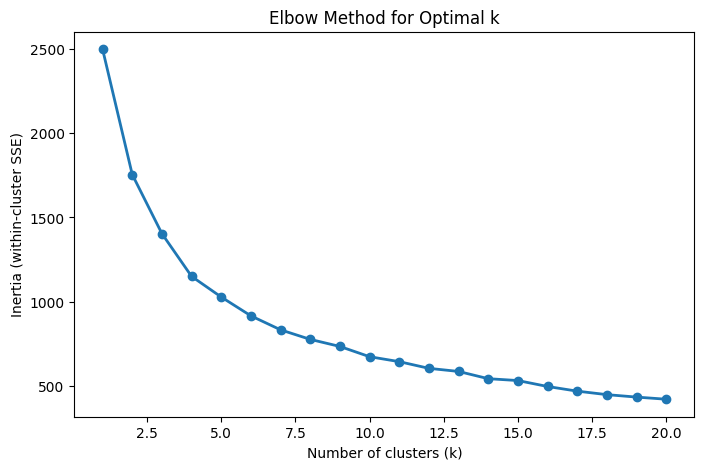

In [ ]:
inertia = []
K = range(1, 21)  # test 1 to 10 clusters

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia, 'o-', linewidth=2)
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (within-cluster SSE)")
plt.title("Elbow Method for Optimal k")
plt.show()


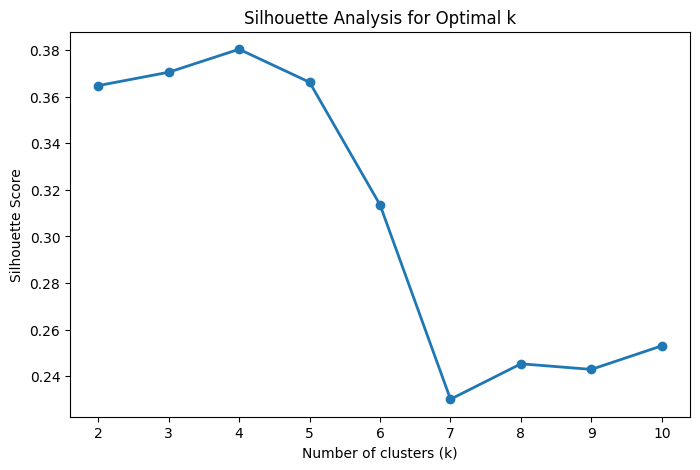

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in range(2, 11):  # silhouette needs k>=2
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8,5))
plt.plot(range(2, 11), silhouette_scores, 'o-', linewidth=2)
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis for Optimal k")
plt.show()


In [130]:
k = np.argmax(silhouette_scores)

kmeans = KMeans(n_clusters=k, random_state=42)
user_filtered = user_filtered.copy()
user_filtered["cluster"] = kmeans.fit_predict(X_scaled)

In [131]:
# user_filtered["score"] = (
#     user_filtered["area"] + user_filtered["quartos"] +
#     user_filtered["banheiros"] + user_filtered["vagas"]
# ) / user_filtered["Total"]

user_filtered["score"] = (user_filtered["area"]) / user_filtered["Total"]

# Rank within each cluster
ranked = user_filtered.sort_values(["cluster", "score"], ascending=[True, False])

In [132]:
ranked.head()


,area,quartos,suite,banheiros,vagas,pet,mobiliado,metro_proximo,Aluguel,Condomínio,IPTU,Seguro incêndio,Taxa de serviço,Total,neighborhood,price_per_m2,cluster,score,PC1,PC2
2073,500.0,2.0,0,1.0,1.0,0,0,0,2000,0.0,0,34,51,2085,vila-maria,4.170000,0,0.239808,0.591061,-3.953836
536,250.0,2.0,0,1.0,0.0,0,0,0,1600,0.0,0,27,41,1668,itaquera,6.672000,0,0.149880,-1.095844,-2.174604
2078,120.0,1.0,0,1.0,0.0,0,0,0,1300,50.0,104,22,33,1509,vila-maria,12.575000,0,0.079523,-1.894523,-1.022271
1411,110.0,2.0,0,1.0,1.0,0,0,0,1615,0.0,184,27,41,1867,sao-miguel-paulista,16.972727,0,0.058918,-0.692881,-1.880834
1449,110.0,2.0,0,1.0,1.0,0,0,0,1615,0.0,184,27,41,1867,sao-miguel-paulista,16.972727,0,0.058918,-0.692881,-1.880834


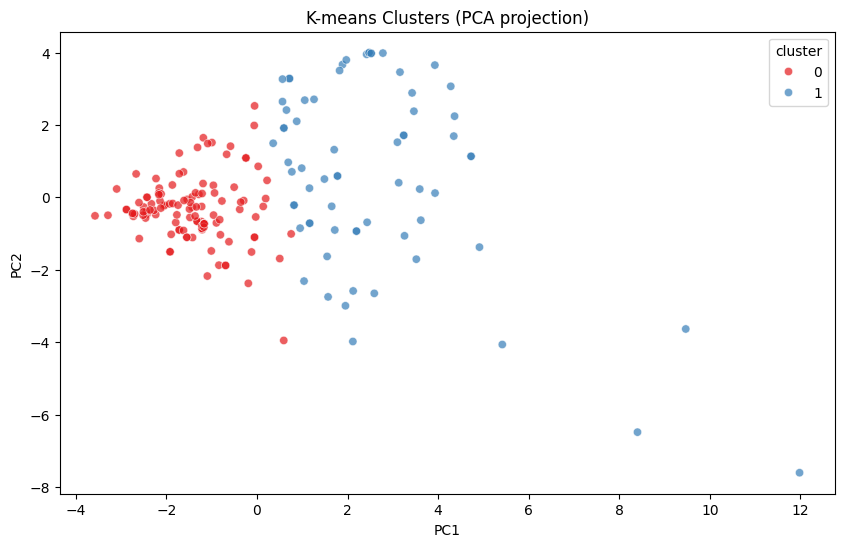

In [133]:
# Reduce scaled features to 2D with PCA
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

# Add the components to the DataFrame
user_filtered = user_filtered.copy()
user_filtered["PC1"] = components[:, 0]
user_filtered["PC2"] = components[:, 1]

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="PC1", y="PC2",
    hue="cluster",
    data=user_filtered,
    palette="Set1",
    alpha=0.7
)
plt.title("K-means Clusters (PCA projection)")
plt.show()


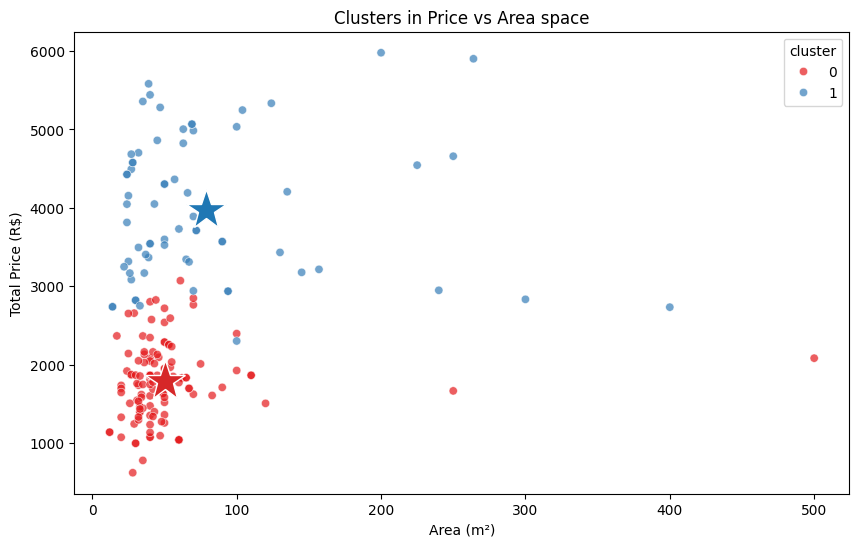

In [145]:
centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=features
)

# print("Cluster centers:\n", centers)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="area", y="Total",
    hue="cluster",
    data=user_filtered,
    palette="Set1",
    alpha=0.7
)
plt.plot(centers['area'].iloc[0], centers['Total'].iloc[0], '*', mfc='tab:red', c='w', ms=30)
plt.plot(centers['area'].iloc[1], centers['Total'].iloc[1], '*', mfc='tab:blue', c='w', ms=30)
plt.title("Clusters in Price vs Area space")
plt.xlabel("Area (m²)")
plt.ylabel("Total Price (R$)")
plt.show()


In [146]:
cluster_scores = user_filtered.groupby("cluster")["score"].mean().sort_values(ascending=False)
print("Cluster ranking:\n", cluster_scores/sum(cluster_scores))


Cluster ranking:
 cluster
0    0.581411
1    0.418589
Name: score, dtype: float64


In [147]:
best_clusters = cluster_scores.index[:1]   # top 1 cluster
best_apartments = user_filtered[user_filtered["cluster"].isin(best_clusters)]

# Show top 5 ranked apartments in the best cluster
recommendations = best_apartments.sort_values("score", ascending=False).head(5)
print(recommendations[["neighborhood", "area", "quartos", "Total", "price_per_m2", "score", "cluster"]])


             neighborhood   area  quartos  Total  price_per_m2     score  \
2073           vila-maria  500.0      2.0   2085      4.170000  0.239808   
536              itaquera  250.0      2.0   1668      6.672000  0.149880   
2078           vila-maria  120.0      1.0   1509     12.575000  0.079523   
1411  sao-miguel-paulista  110.0      2.0   1867     16.972727  0.058918   
1449  sao-miguel-paulista  110.0      2.0   1867     16.972727  0.058918   

      cluster  
2073        0  
536         0  
2078        0  
1411        0  
1449        0  


C:\Users\josea\AppData\Local\Temp\ipykernel_17660\1057810885.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_scores.index, y=cluster_scores.values, palette="viridis")


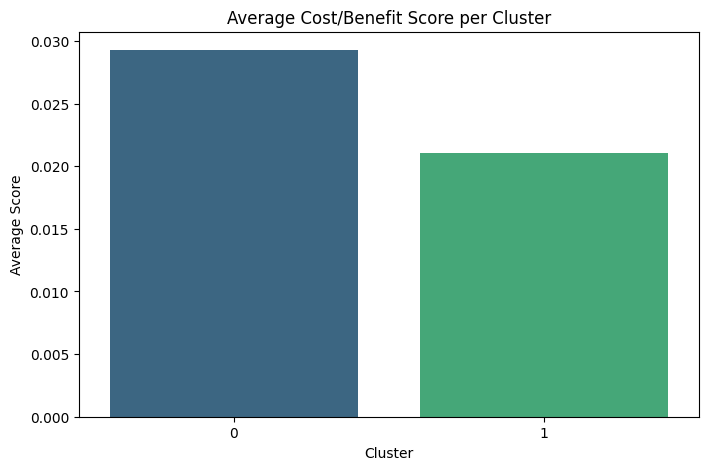

In [148]:
plt.figure(figsize=(8,5))
sns.barplot(x=cluster_scores.index, y=cluster_scores.values, palette="viridis")
plt.title("Average Cost/Benefit Score per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Score")
plt.show()


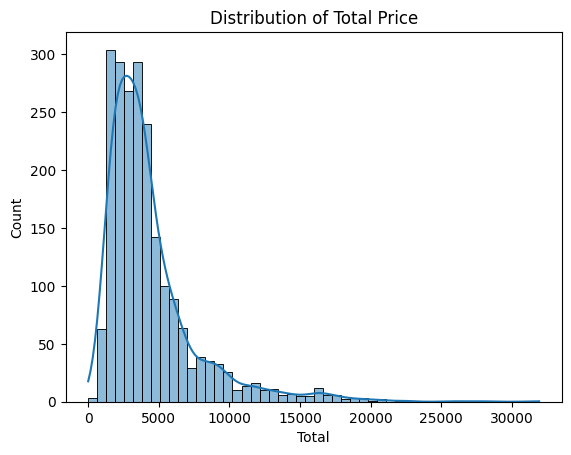

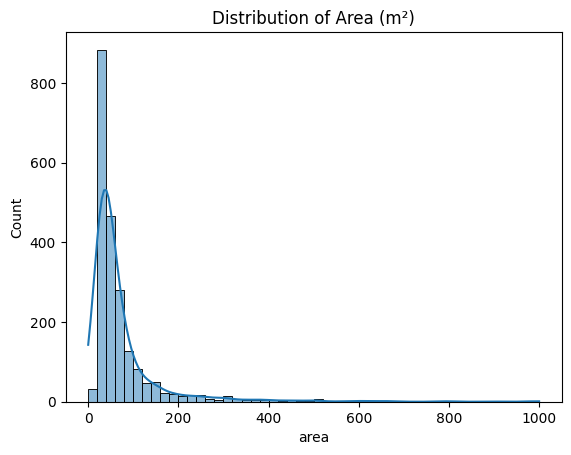

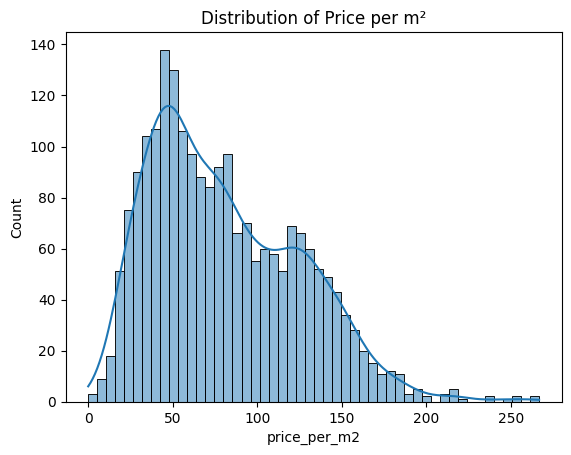

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data_refined["Total"], bins=50, kde=True)
plt.title("Distribution of Total Price")
plt.show()

sns.histplot(data_refined["area"], bins=50, kde=True)
plt.title("Distribution of Area (m²)")
plt.show()

sns.histplot(data_refined["price_per_m2"], bins=50, kde=True)
plt.title("Distribution of Price per m²")
plt.show()



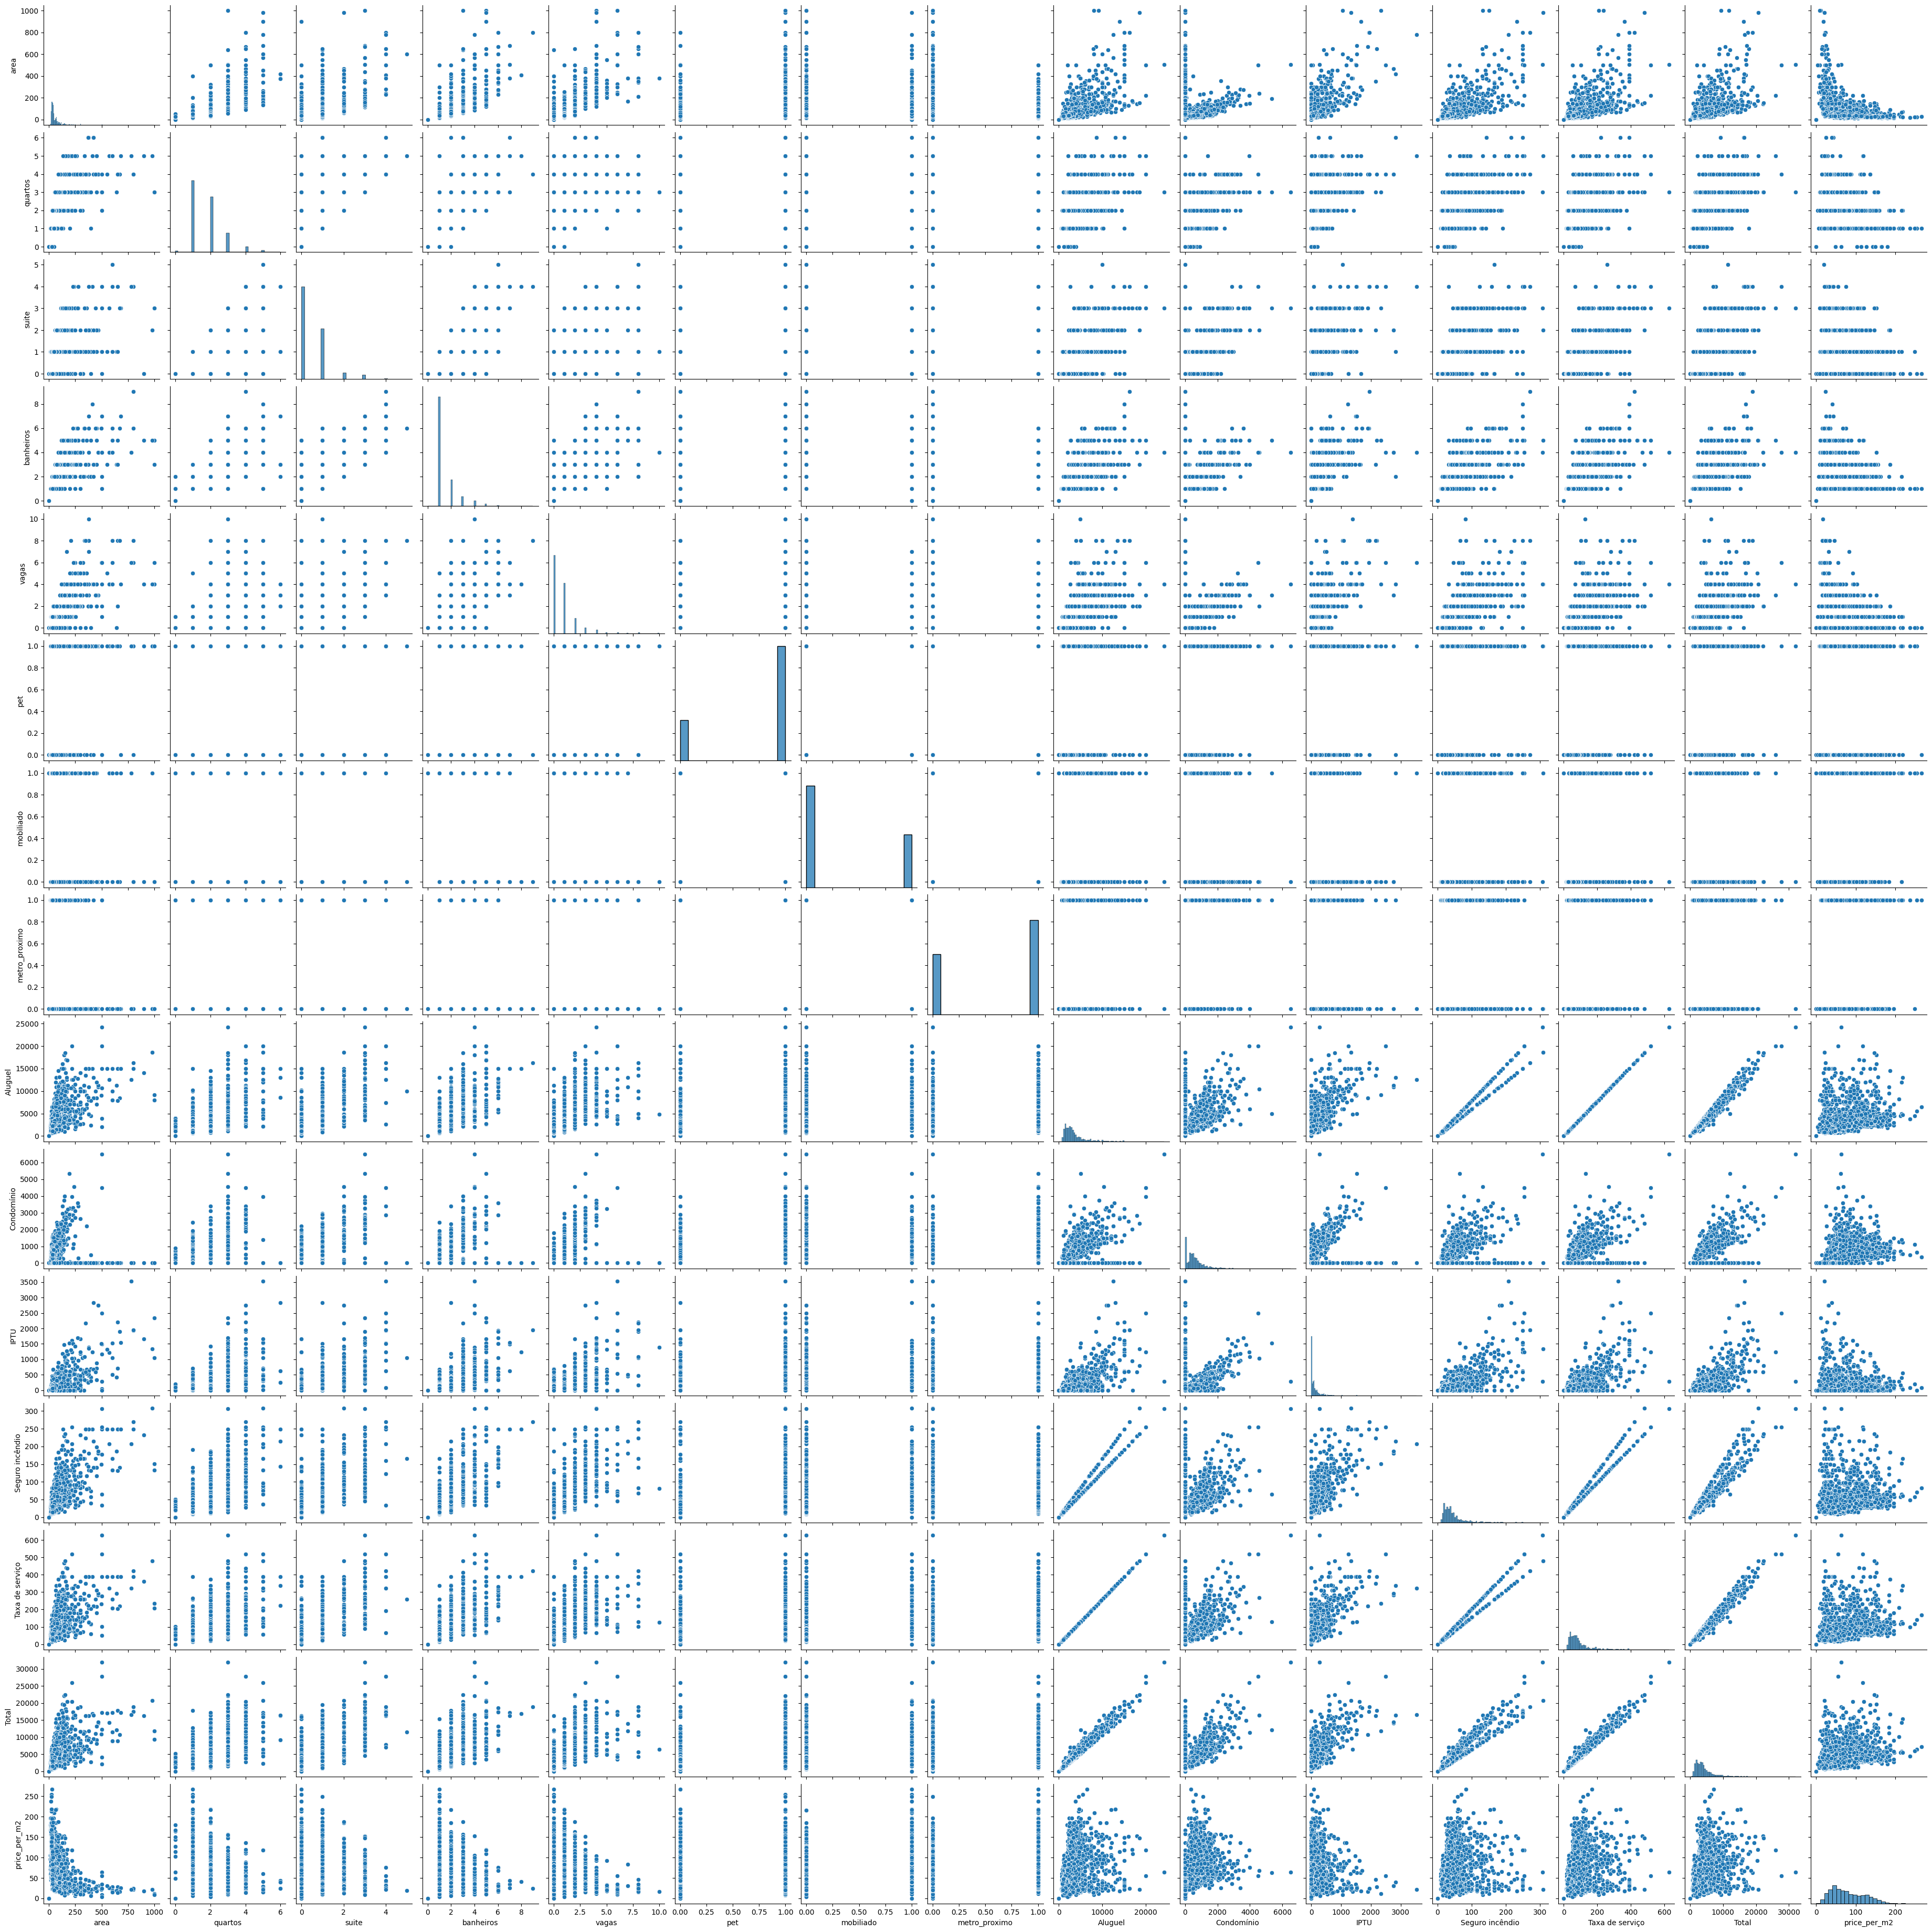

In [61]:
sns.pairplot(data_refined)
plt.show()

In [46]:
data_refined.columns

Index(['area', 'quartos', 'suite', 'banheiros', 'vagas', 'pet', 'mobiliado',
       'metro_proximo', 'Aluguel', 'Condomínio', 'IPTU', 'Seguro incêndio',
       'Taxa de serviço', 'Total', 'neighborhood', 'price_per_m2'],
      dtype='object')

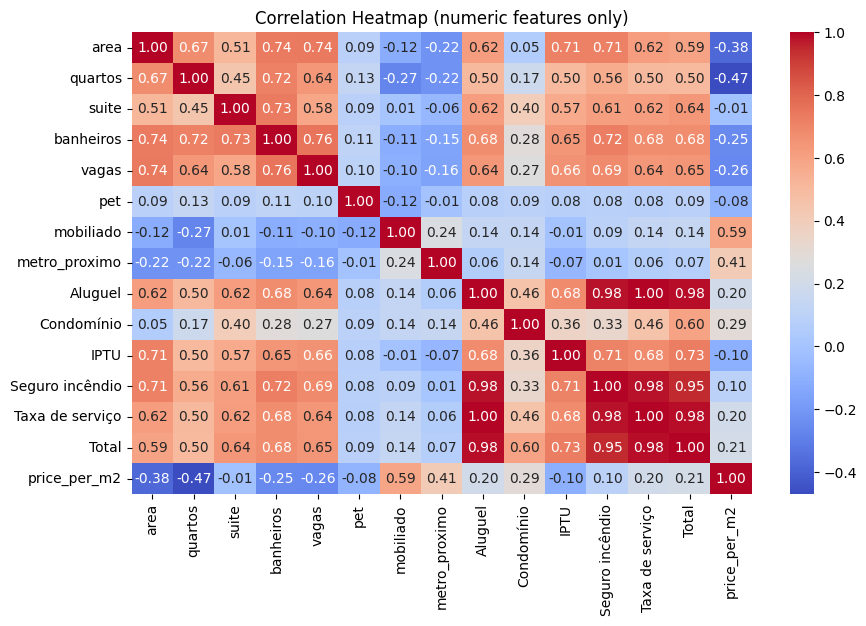

In [48]:
cols_to_numeric = ['area', 'quartos', 'suite', 'banheiros', 'vagas', 'pet', 'mobiliado',
       'metro_proximo', 'Aluguel', 'Condomínio', 'IPTU', 'Seguro incêndio',
       'Taxa de serviço', 'Total', 'price_per_m2']

for col in cols_to_numeric:
    if col in data_refined.columns:
        data_refined[col] = pd.to_numeric(data_refined[col], errors="coerce").fillna(0)

numeric_data = data_refined.select_dtypes(include=["int64", "float64"])

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(numeric_data.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap (numeric features only)")
plt.show()


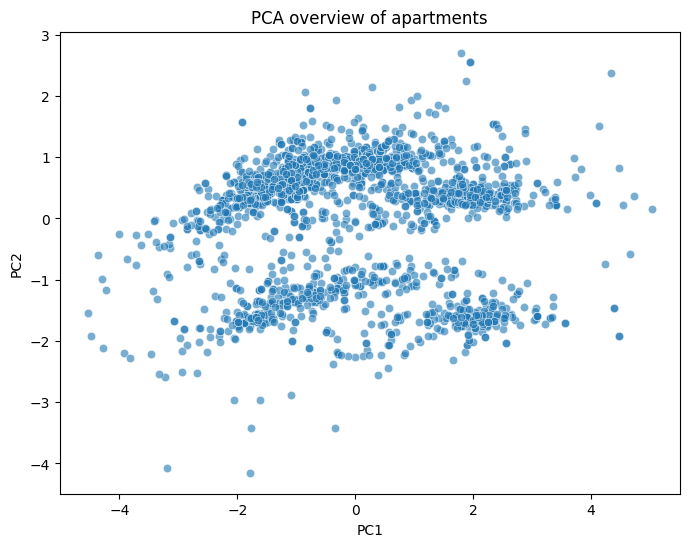

Explained variance ratio: [0.4944251  0.17310614 0.06997531 0.05363398 0.05044624 0.04133617
 0.03261299 0.02982337 0.01958958 0.01378204]


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Scale features
features = data_refined.select_dtypes(include=[float, int])
scaled = StandardScaler().fit_transform(features)

# Apply PCA
pca = PCA(n_components=10)
components = pca.fit_transform(scaled)

# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=components[:, 1], y=components[:, 2], alpha=0.6)
plt.title("PCA overview of apartments")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_)

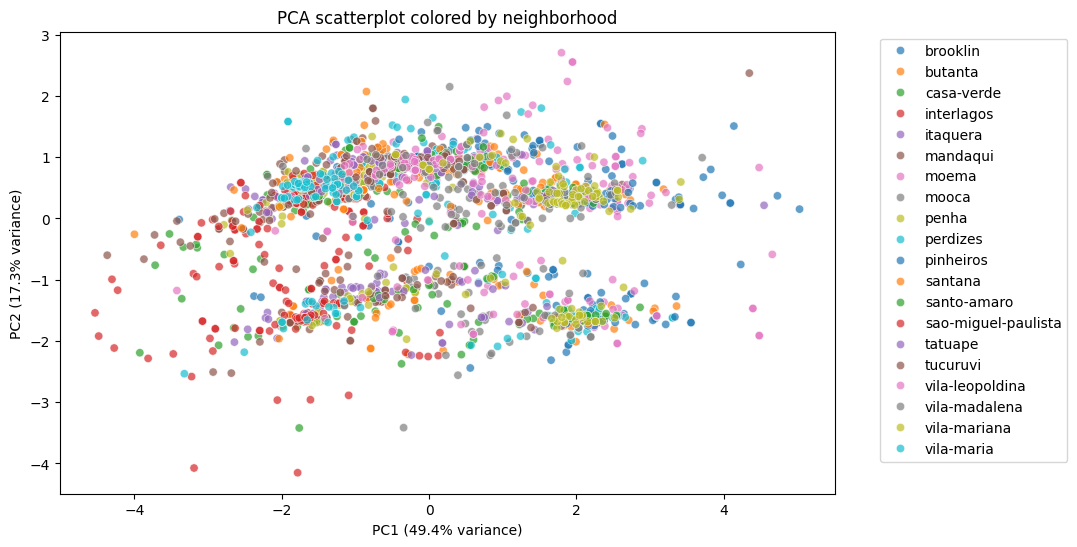

In [69]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Select numeric features (X = inputs for PCA)
X = data_refined.select_dtypes(include=["number"])

# 2. Keep neighborhood column for coloring later
neighborhood = data_refined["neighborhood"].astype(str)

# 3. Scale the data
X_scaled = StandardScaler().fit_transform(X)

# 4. PCA to 2D
pca = PCA(n_components=3)
components = pca.fit_transform(X_scaled)

# 5. Plot with neighborhoods as hue
plt.figure(figsize=(10, 6))
sns.scatterplot(x=components[:, 1], y=components[:, 2], hue=neighborhood, palette="tab10", alpha=0.7)
plt.title("PCA scatterplot colored by neighborhood")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


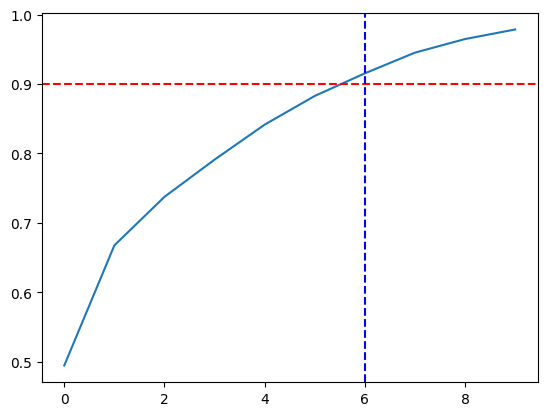

In [60]:
plt.plot(range(10), np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=0.9, ls='--', c='r')
plt.axvline(x=6, c='b', ls='--')
plt.show()